# About: Using Selenium

Jupyter NotebookからSeleniumを使ってみる例です。

1. GitHubリポジトリ https://github.com/yacchin1205/jupyter-with-jenkins を開き
2. `conf`ディレクトリの中身を覗く
3. サーバーの応答時間を可視化する

ことをしてみます。

# 準備

必要なライブラリをインポートします。

In [1]:
import time
import os
from IPython.display import Image

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

WebDriverを準備します。本環境にはChrome Driverのみインストールしています。(Firefoxとか、Pull Requestもらえると嬉しかったり)

> サーバーの応答時間を可視化するために、Chromeを前提としたパラメータを指定しています。

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--lang=ja')

# DriverからPerfomance Logを取得し、これをHARとして整形する
# 参考: https://stackoverflow.com/questions/18075645/export-har-using-chromedriver
perf_log_prefs = dict(traceCategories='browser,devtools.timeline,devtools', enableNetwork=True, enablePage=True)
chrome_options.add_experimental_option('perfLoggingPrefs', perf_log_prefs)

caps = webdriver.DesiredCapabilities.CHROME.copy() 
caps['goog:loggingPrefs'] = {'performance': 'ALL', 'browser': 'ALL'}

driver = webdriver.Chrome(options=chrome_options, desired_capabilities=caps)

スクリーンショットを取得するための一時ディレクトリを準備しておきます。

In [3]:
import tempfile
work_dir = tempfile.mkdtemp()
work_dir

'/tmp/tmpdjprxbzv'

# テストの実施

## ブラウザを開く

WebDriverを使って、URLを指定してブラウザを開きます。

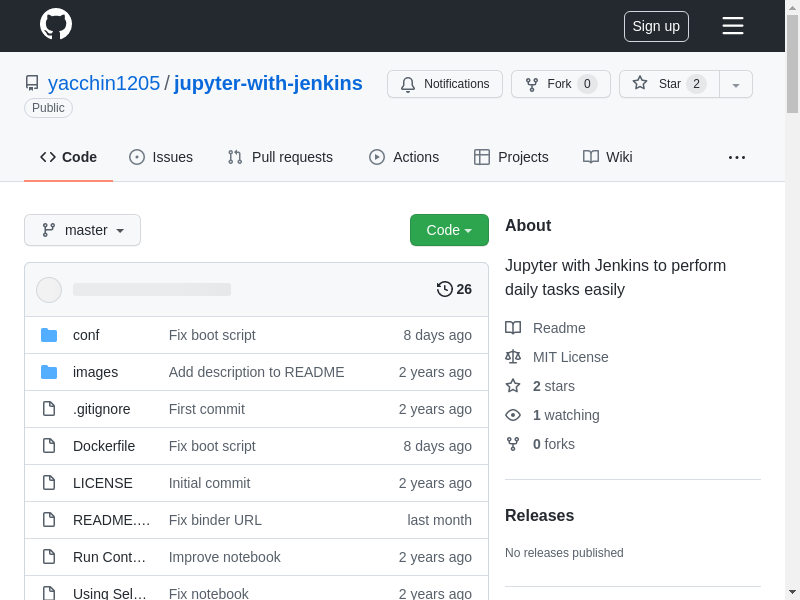

In [4]:
url = 'https://github.com/yacchin1205/jupyter-with-jenkins'
driver.get(url)

# Output the screenshot
driver.save_screenshot(os.path.join(work_dir, 'sample.png'))
Image(os.path.join(work_dir, 'sample.png'))

## 画面遷移の確認

`conf`ディレクトリの中身を覗いてみます。

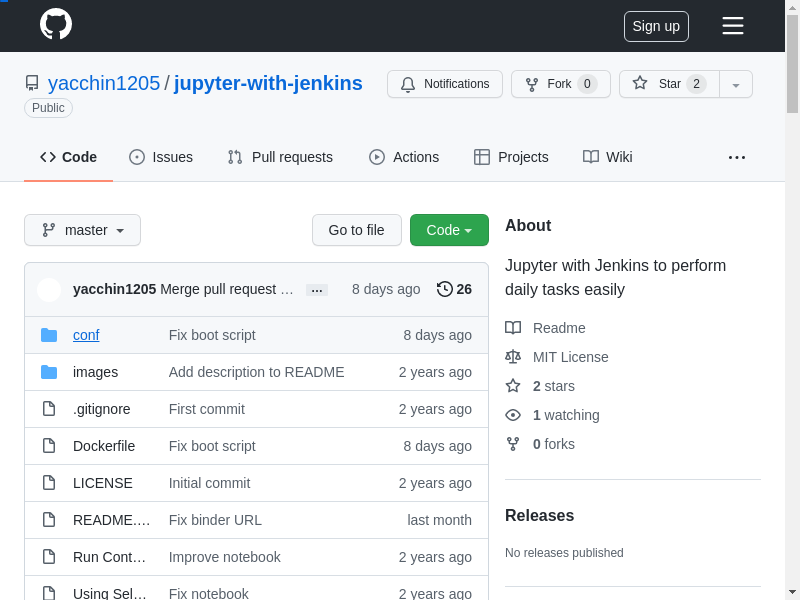

In [5]:
elem = driver.find_element(By.XPATH, '//a[text() = "conf"]')
elem.click()

driver.save_screenshot(os.path.join(work_dir, 'sample.png'))
Image(os.path.join(work_dir, 'sample.png'))

クリック後即confディレクトリが表示されるわけではないので... `time.sleep`等で適宜待機してから確認するのが良いかもしれません。

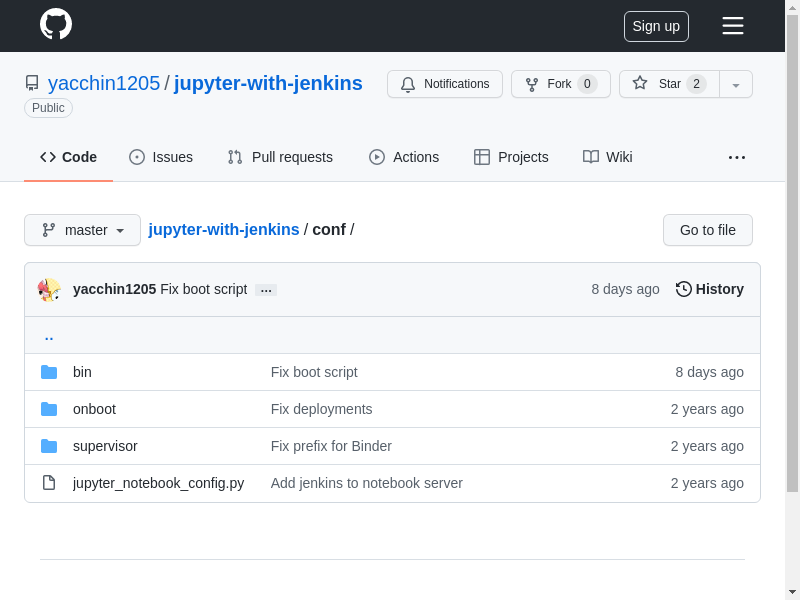

In [6]:
time.sleep(5)

driver.save_screenshot(os.path.join(work_dir, 'sample.png'))
Image(os.path.join(work_dir, 'sample.png'))

## 要素が存在しているかチェック

このように画面遷移をさせながら、適宜予期した要素が存在しているかなど日々チェックできると安心かなと。

以下のコードは期待した要素が存在していないと`NoSuchElementException`で失敗します。

In [7]:
# If the expected file does not exist, it fails with NoSuchElementException
driver.find_element(By.XPATH, '//a[text() = "jupyter_notebook_config.py"]')

<selenium.webdriver.remote.webelement.WebElement (session="cf6a11b586fc37584d6fe5e5a3ac71a6", element="002249c1-6a39-4d98-9d0e-20e29f13cbb7")>

# 応答速度確認

この例では [harファイル](https://toolbox.googleapps.com/apps/har_analyzer/?lang=ja) を取得してみます。HAR Analyzer等のアプリケーションを利用することで、Webサイトのパフォーマンスを詳細に分析することができます。

In [8]:
import requests
import json

# DriverからPerfomance Logを取得し、これをHARとして整形する
# 参考: https://stackoverflow.com/questions/18075645/export-har-using-chromedriver
def get_perf_entry_logs(driver):
    r = []
    for log in driver.get_log('performance'):
        r.append(json.loads(log['message'])['message'])
    return r

def load_har(driver):
    r = requests.get('https://cdn.jsdelivr.net/gh/Ankit3794/chrome_har_js@master/chromePerfLogsHAR.js')
    r.encoding = r.apparent_encoding
    perf_logs_har_script = r.text

    driver.execute_script(perf_logs_har_script);
    har_body = driver.execute_script("return module.getHarFromMessages(arguments[0])", json.dumps(get_perf_entry_logs(driver)))
    return json.loads(har_body)

har_data = load_har(driver)
har_data

{'log': {'version': '1.2',
  'creator': {'name': 'chrome-har',
   'version': '0.11.4',
   'comment': 'https://github.com/sitespeedio/chrome-har'},
  'pages': [{'id': 'page_1',
    'startedDateTime': '2022-02-20T04:30:37.001Z',
    'title': 'https://github.com/yacchin1205/jupyter-with-jenkins',
    'pageTimings': {'onContentLoad': 972.959, 'onLoad': 1120.818}}],
  'entries': [{'cache': {},
    'startedDateTime': '2022-02-20T04:30:37.002Z',
    '_requestId': 'C16042C038653D370E3B2B2DEDE6DBE0',
    '_initialPriority': 'VeryHigh',
    '_priority': 'VeryHigh',
    'pageref': 'page_1',
    'request': {'method': 'GET',
     'url': 'https://github.com/yacchin1205/jupyter-with-jenkins',
     'queryString': [],
     'headersSize': -1,
     'bodySize': 0,
     'cookies': [],
     'headers': [{'name': 'Upgrade-Insecure-Requests', 'value': '1'},
      {'name': 'User-Agent',
       'value': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/98.0.4758.80 Safari/537

URLごとにtimeの項目を抽出してみます。

In [9]:
import pandas as pd

perf_df = pd.DataFrame([(e['request']['url'], e['time']) for e in har_data['log']['entries']], columns=['URL', 'time_ms'])
perf_df

,URL,time_ms
0,https://github.com/yacchin1205/jupyter-with-je...,505.881
1,https://github.githubassets.com/assets/light-7...,173.403
2,https://github.githubassets.com/assets/dark-52...,174.183
3,https://github.githubassets.com/assets/framewo...,237.035
4,https://github.githubassets.com/assets/behavio...,243.826
...,...,...
57,https://collector.github.com/github/collect,222.101
58,https://github.com/yacchin1205/jupyter-with-je...,202.184
59,https://github.com/yacchin1205/jupyter-with-je...,205.023
60,https://api.github.com/_private/browser/stats,170.633


time_msの分布をヒストグラムで出しておくと、応答時間の傾向を把握できるかもしれません。

<AxesSubplot:>

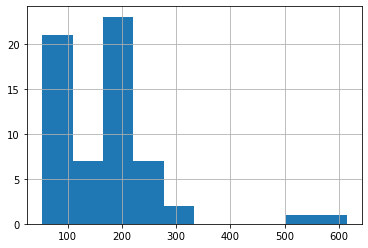

In [10]:
perf_df['time_ms'].hist()

harファイルは日付をつけて`har` ディレクトリに保存しておくことにします。
あとで問題が起きた時に分析したり、長期的なトレンドを分析するのに役立つかもしれません。

In [11]:
from datetime import datetime

har_files_path = './har'
!mkdir -p {har_files_path}

# ファイル名はyyyymmddhhmmssとする - 環境のTimezoneに注意
filename = 'selenium-' + datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
with open(os.path.join(har_files_path, f'{filename}.json'), 'w') as f:
    f.write(json.dumps(har_data))
!ls -la {har_files_path}

total 484
drwxr-sr-x.  2 jovyan users   4096 Feb 20 04:30 .
drwsrwsr-x+ 20 jovyan users   4096 Feb 20 04:29 ..
-rw-r--r--.  1 jovyan users 238520 Feb 20 04:27 selenium-2022-02-20-04-28-27.json
-rw-r--r--.  1 jovyan users 242732 Feb 20 04:30 selenium-2022-02-20-04-30-45.json


# 後始末

忘れず一時ファイルは削除しておきましょう。

In [12]:
!rm -fr {work_dir}